# Gravitational Wave Detection

This is the final project done as part of the General Assembly's Data Science Immersive in Jul/Aug 2021.

In this notebook we will build the `TensorFlow` input data pipeline, build, train & evaluate binary classification model to predict if the given set of signals has Gravitational Waves in them or not. As mentioned in the analysis notebook, we will be using _Deep Learning_ models, specifically image classification models in this project. For evaluation metrics, ROC AUC (receiver operating charateristics area under curve) is used.

**Data Pipeline**

A well structured data pipeline, if used, can create an efficient workflow by consolidating all the data imports, preprocessing & manipulations into cleanly defined functions. This can be unavoidable, if dealing with large datasets, such as in this project, which might not be possible to load at once due to memory limitations. `TensorFlow`'s [`tf.data`](https://www.tensorflow.org/guide/data) API can assist in building this complex yet flexible and modular pipeline. It also enables to optimize our workflow for GPU and TensorFlow provides methods that can be run on GPU instead, while handling data as `tf.tensor`, that can run more than 5 times faster depending on the situation.

**Modelling Strategy**

There are mainly two methodologies we followed in the project, since this is essentially a signal processing problem with classification task, there can be two ways in which we can build models around this data, as also mentioned in the analysis notebook - using "raw" signals with minimal pre-processing and using "images" by transforming the waves into spectrograms. However, building models on raw signal data, by following the cleaning steps from respective publications, didnot yield acceptable results. It is worth mentioning that only a part of the data was used while strategy selection process, and it was concluded that more pre-processing was necessary, or rather proper pre-processing, if we were to use raw signal.

Eventually, the second method that we went with in this project, is used to transform the waves into the spectrogram image. We train two models to evaluate the results:
1. Simple CNN- a simple CNN architecture that is a modified version of the model usually used in MNIST Digit Recognizer tutorials. This acts as our baseline model.
2. SOTA EfficientNet- a state-of-the-art [`EfficientNetB0`](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) model that has been developed and pre-trained on ImageNet dataset. This model is chosen as it is known for its near-SOTA performance with significantly fewer number of parameters, that can drastically improve the computational efficiency.

The EfficientNetB0 is the "entry-level" model we choose from a whole range of models available. We split the train dataset given into - training & validations - in 75~25 ratio. Both the models are initally trained on the training dataset and validate on the validation dataset, and once acceptable convergence is seen on the metrics, we re-train the models on the validation dataset so the models have seen the entire training data before we make predictions for the test dataset.

**Evaluation**

We compile both the models to keep track of two metrics, ROC AUC and accuracy. The focus will be on looking out for a good AUC value, which tells us that the model is good at separating the two classes well, and accuracy will give us a sense of overall performance. We will compare the two models later and also see what kaggle submission scores we get from our predictions for the test dataset.

#### Contents

The contents of this notebook are as follows:
- [Imports](#Imports)

- [Modelling](#Modelling)

- [Evaluation](#Evaluation)

- [Results & Conclusions](#Results-&-Conclusions)

**Note:** This notebook was developed and run in the kaggle notebook environment.

### Imports

#### Import the libraries

We are using `TensorFlow` to build the models in this project, so import the relevant methods from the library.

In [1]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting tools

# Train test split
from sklearn.model_selection import train_test_split

# Import tensorflow
import tensorflow as tf

# Model & compile arguments
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Get the layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten

# Import the Efficientnet models
from tensorflow.keras.applications import EfficientNetB0

# TF model metrics
from tensorflow.keras.metrics import AUC

# 
import librosa
import torch

# (Install &) Import the nnAudio library for Constant Q-Transform
try:
    from nnAudio.Spectrogram import CQT1992v2
except:
    !pip install -q nnAudio
    from nnAudio.Spectrogram import CQT1992v2
    
# Run the state-of-the-art model
!pip install -U efficientnet
import efficientnet.keras as efn

**Note:** The `nnAudio`'s `CQT1992v2` is used, instead of `GWpy` from analysis notebook, to transform the wave data into Constant Q-Transform spectrograms because this performs the operation much faster and is GPU compatible (when used with appropriate workflow). One caveat is that this library is bsaed on `PyTorch` and thus takes `torch.tensor` as its input instead of `tf.tensor`.

In [2]:
# Function to save kaggle submissions for test prediction probabilities
def get_kaggle_format(prediction_probs, model='base'):
    # load the sample submission file
#     sub = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
    sample_sub['target'] = prediction_probs
    
    # Output filename for kaggle submission
    filename = f"kaggle_sub_{model}.csv"
    
    # Save the DataFrame to a file
    sample_sub.to_csv(filename, index=False)
    print(f'File name: {filename}')

#### Import the training and submission labels

The dataset is available from the **G2Net Gravitational Wave Detection** on [kaggle](https://www.kaggle.com/c/g2net-gravitational-wave-detection/data), but since this website is run in kaggle notebook environment, we use the local relative links to import the data.

In [3]:
# Get the training ids
train = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')

# Get the subsmission file
sample_sub = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

In [4]:
print(f'Training labels: {train.shape[0]} | Test dataset: {sample_sub.shape[0]}')

Training labels: 560000 | Test dataset: 226000


There are 560000 training and 226000 test data observations in total. As mentioned in the competition description, each of these are `id`s that is the filename, which in the local directory contains 3 timeseries samples from the 3 observatories.

In [5]:
# fraction of entire dataset, use 1 if running on whole data
data_size = 1

# if not using entire dataset, sample it
if data_size != 1.0:
    train = train.sample(frac=data_size, random_state=42)
    sample_sub = sample_sub.sample(frac=data_size, random_state=42)

In [6]:
# Training dataset to use
train.shape

(560000, 2)

In [7]:
# check train dataset contents 
train.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [8]:
# Test dataset to use
sample_sub.shape

(226000, 2)

#### Baseline score

Since this binary classification can be divided into positive and negative class, we can define a _baseline score_ based on the target variable distribution.

In [9]:
# Target distribution in the training data
train['target'].value_counts(normalize=True)

0    0.500125
1    0.499875
Name: target, dtype: float64

The distribution is almost even with 50-50 division between the samples with and without gravitational waves signal. In reality though, usually this is not the case, since the gravitational waves are such rare events, there will be huge imbalance between the two. But since this data was generated using simulation by the competition hosts, we use it as it is.

In [9]:
# let's define some signal parameters
sample_rate = 2048 # data is provided at 2048 Hz
signal_length = 2 # each signal lasts 2 s
fmin, fmax = 20, 1024 # filter above 20 Hz, and max 1024 Hz (Nyquist freq = sample_rate/2)
hop_length = 64 # hop length parameter for the stft

# model compile params
batch_size = 250 # size in which data is processed and trained at-once in model
epochs = 3 # number of epochs (keep low as dataset is quite large 3~5 is enough as observed)

### Creating TF Data pipeline

Next, we create the TensorFlow input data pipeline. This is crucial as loading such a huge dataset can create a bottleneck on the entire workflow and can cause memory overload.

#### Fetch & Preprocess Data

In [10]:
# function to return the npy file corresponding to the id
def get_npy_filepath(id_, is_train=True):
    path = ''
    if is_train:
        return f'../input/g2net-gravitational-wave-detection/train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
    else:
        return f'../input/g2net-gravitational-wave-detection/test/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'

In [12]:
# Define the Constant Q-Transform
cq_transform = CQT1992v2(sr=sample_rate, fmin=fmin, fmax=fmax, hop_length=hop_length)

# check if GPU enabled, then run the transform on GPU for faster execution
# if tf.test.is_gpu_available():
#     cq_transform = cq_transform.to('cuda')

CQT kernels created, time used = 0.0367 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [13]:
# function to load the file, preprocess, return the respective Constant Q-transform
def parse_function(id_path):
    # load the npy file
    signals = np.load(id_path.numpy())
    
    # loop through each signal
    for i in range(signals.shape[0]):
        # normalize the signal data
        signals[i] /= np.max(signals[i])
    
    # stack the arrays into a single vector
    signals = np.hstack(signals)
    
    # convert the signals to torch.tensor to pass to CQT
    signals = torch.from_numpy(signals).float()
    
    # get the CQT
    image = cq_transform(signals)
    
    # conver the image from torch.tensor to array
    image = np.array(image)
    
    # transpose the image to get right orientation
    image = np.transpose(image,(1,2,0))
    
    # conver the image to tf.tensor and return
    return tf.convert_to_tensor(image)

(69, 193, 1)


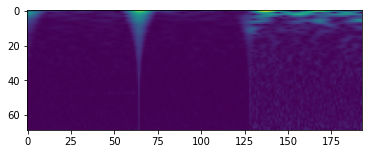

In [14]:
# plot a sample
image = parse_function(tf.convert_to_tensor(get_npy_filepath(train['id'].values[0])))
print(image.shape)
plt.imshow(image)

In [15]:
# From the Constant Q-Transform that we got, get the shape
input_shape = (69, 193, 1)

In [16]:
# Get the feature ids and target
X = train[['id']]
y = train['target'].astype('int8').values

In [17]:
# Split the training IDs into training & validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, stratify=y)

# Assign the test IDs
X_test = sample_sub[['id']]

In [18]:
# the tf_function which is called in the data pipeline. This runs as TF function
def tf_parse_function(id_path, y=None):
    # pass the id_path to the py_function parse_function
    [x] = tf.py_function(func=parse_function, inp=[id_path], Tout=[tf.float32])
    
#     x.set_shape(signal_shape) # signal_shape
    x = tf.ensure_shape(x, input_shape)
    
    # if train/valid then return x, y; for test only return x
    if y is None:
        return x
    else:
        return x, y

#### Define the dataset objects

In [19]:
# train dataset
# Get the data filepaths as tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train['id'].apply(get_npy_filepath).values, y_train))

# shuffle the dataset
train_dataset = train_dataset.shuffle(len(X_train))

# apply the map method to tf_parse_function()
train_dataset = train_dataset.map(tf_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

# set batch size of the dataset
train_dataset = train_dataset.batch(batch_size)

# prefetch the data
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [20]:
# valid dataset
# Get the data filepaths as tensor_slices
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid['id'].apply(get_npy_filepath).values, y_valid))

# apply the map method to tf_parse_function()
valid_dataset = valid_dataset.map(tf_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

# set batch size of the dataset
valid_dataset = valid_dataset.batch(batch_size)

# prefetch the data
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)

In [21]:
# test dataset
# Get the data filepaths as tensor_slices
test_dataset = tf.data.Dataset.from_tensor_slices((X_test['id'].apply(get_npy_filepath, is_train=False).values))

# apply the map method to tf_parse_function()
test_dataset = test_dataset.map(tf_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

# set batch size of the dataset
test_dataset = test_dataset.batch(batch_size)

# prefetch the data
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### Modelling

Now, we can start building the models. As mentioned above, we will define a simple CNN model first, followed by a SOTA EfficientNet model.

In [22]:
# Get the signal input shape
for x, _ in train_dataset.take(1):
    input_shape = x.shape[1:]

In [23]:
# function to print the learning curves for the models
# adapted from https://www.tensorflow.org/tutorials/images/transfer_learning#learning_curves
def learning_curves(history, model='cnn'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if model == 'efn':
        auc = history.history['auc_2']
        val_auc = history.history['val_auc_2']
    else:
        auc = history.history['auc']
        val_auc = history.history['val_auc']
    
    plt.figure(figsize=(12, 12))    
    plt.subplot(3, 1, 1)
    plt.plot(auc, label='Training AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation AUC')
    plt.xlabel('epoch')
    plt.show()
    
    plt.subplot(3, 1, 2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.subplot(3, 1, 3)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

#### Baseline Model

Let's build and train a simple CNN model as our baseline model before we build more advanced models.

In [24]:
# Instantiate the Sequential model
model_cnn = Sequential(name='CNN_model')

# Add the first Convoluted2D layer w/ input_shape & MaxPooling2D layer followed by that
model_cnn.add(Conv2D(filters=16,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_01'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_01'))

# Second pair of Conv1D and MaxPooling1D layers
model_cnn.add(Conv2D(filters=32,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_02'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_02'))

# Third pair of Conv1D and MaxPooling1D layers
model_cnn.add(Conv2D(filters=64,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_03'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_03'))

# Add the Flatten layer
model_cnn.add(Flatten(name='Flatten'))

# Add the Dense layers
model_cnn.add(Dense(units=512,
                activation='relu',
                name='Dense_01'))
model_cnn.add(Dense(units=64,
                activation='relu',
                name='Dense_02'))

# Add the final Output layer
model_cnn.add(Dense(1, activation='sigmoid', name='Output'))

In [25]:
# Display the CNN model architecture
model_cnn.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_01 (Conv2D)             (None, 67, 191, 16)       160       
_________________________________________________________________
Pool_01 (MaxPooling2D)       (None, 33, 95, 16)        0         
_________________________________________________________________
Conv_02 (Conv2D)             (None, 31, 93, 32)        4640      
_________________________________________________________________
Pool_02 (MaxPooling2D)       (None, 15, 46, 32)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 13, 44, 64)        18496     
_________________________________________________________________
Pool_03 (MaxPooling2D)       (None, 6, 22, 64)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 8448)              0 

In [26]:
# compile the model with following parameters
# Optimizer: Adam (learning_rate=0.0001)
# loss: binary_crossentropy
# metrics: accuracy/AUC
model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

In [27]:
# Fit the data
history_cnn = model_cnn.fit(x=train_dataset,
                            epochs=epochs,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/3
1680/1680 [==============================] - 3253s 2s/step - loss: 0.5712 - auc: 0.7465 - accuracy: 0.6762 - val_loss: 0.4825 - val_auc: 0.8295 - val_accuracy: 0.7556
Epoch 2/3
1680/1680 [==============================] - 3364s 2s/step - loss: 0.4853 - auc: 0.8261 - accuracy: 0.7549 - val_loss: 0.4811 - val_auc: 0.8360 - val_accuracy: 0.7550
Epoch 3/3
1680/1680 [==============================] - 3414s 2s/step - loss: 0.4753 - auc: 0.8325 - accuracy: 0.7614 - val_loss: 0.4670 - val_auc: 0.8388 - val_accuracy: 0.7667


In [28]:
# save the model
model_cnn.save('./model_CNN.h5')

The baseline model seems to be converging well only after about 3 epochs. But as you can see, it takes almost about an hour to train each epoch, we can only say that the model can be improved with further training and fine-tuning the structure. At the end of 3rd epoch, we see 0.83 AUC score and 0.76 accuracy for training dataset, while 0.84 AUC score and 0.77 accuracy for the validation dataset.

#### SOTA Model

Our baseline model performed quite well actually, but it was a very simple model which we trained for our particular dataset from scratch, however, there are more advanced and pre-trained _state-of-the-art_ models that we can try to use for our classification task. _EfficientNet_ is one such model architecture that has been researched extensively recently, and has achieved _state-of-the-art_ level accuracy as compared to other models on ImageNet data with significantly fewer number of parameters, which means faster training times. Although, the Constant Q-Transforms we use aren't exactly images, but these models can be "retrained" to adapt to other images with large datasets. And as we have a large dataset, we can use these models, with and without pretrained weights to see if we get better results than our baseline. This model is run in another notebook where we save the model, but we can simply load/attach this model into this notebook as input and perform the predictions.

**Note:** Check the local directory and adjust accordingly for filepaths, before running.

In [ ]:
# load the trained EfficientNet model from the other notebook
model_efn = tf.keras.models.load_model('../assets/model_EFN.h5')

In [30]:
# Instantiate the Sequential model
model_efn = Sequential(name='EfficientNet_model')

# Add the first Convoluted2D layer w/ input_shape
model_efn.add(Conv2D(filters=3,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     padding='same',
                     name='Conv_01'))

# Add the EfficientNetB0 model and a MaxPooling2D layer
model_efn.add(EfficientNetB0(include_top=False,
                             weights='imagenet'))
# model_efn.add(MaxPooling2D(pool_size=2, name='Pool_01'))
model_efn.add(GlobalAveragePooling2D())

# Add the Flatten layer
# model_efn.add(Flatten(name='Flatten'))

# Add the Dense layers
model_efn.add(Dense(units=64,
                activation='relu',
                name='Dense_01'))

# Add the final Output layer
model_efn.add(Dense(1, activation='sigmoid', name='Output'))

16711680/16705208 [==============================] - 0s 0us/step


In [31]:
# Display the EfficientNet model architecture
model_efn.summary()

Model: "EfficientNet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_01 (Conv2D)             (None, 69, 193, 3)        30        
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
Dense_01 (Dense)             (None, 64)                81984     
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 4,131,650
Trainable params: 4,089,627
Non-trainable params: 42,023
_________________________________________________________________


In [32]:
# compile the model with following parameters
# Optimizer: Adam (learning_rate=0.001)
# loss: binary_crossentropy
# metrics: accuracy/AUC
model_efn.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])

In [33]:
# Fit the data
history_efn = model_efn.fit(x=train_dataset,
                            epochs=epochs,
                            validation_data=valid_dataset,
                            batch_size=batch_size,
                            verbose=1)

Epoch 1/3
1680/1680 [==============================] - 3667s 2s/step - loss: 0.5017 - auc_1: 0.8064 - accuracy: 0.7389 - val_loss: 0.7152 - val_auc_1: 0.5258 - val_accuracy: 0.5001
Epoch 2/3
1680/1680 [==============================] - 3739s 2s/step - loss: 0.4490 - auc_1: 0.8492 - accuracy: 0.7787 - val_loss: 48.8530 - val_auc_1: 0.5000 - val_accuracy: 0.4999
Epoch 3/3
1680/1680 [==============================] - 3867s 2s/step - loss: 0.4410 - auc_1: 0.8540 - accuracy: 0.7854 - val_loss: 121.6031 - val_auc_1: 0.5000 - val_accuracy: 0.4999


In [34]:
# save the model
model_efn.save('./model_EFN.h5')

#### Test Predictions

Train the model on the validation data before making the final test predictions

In [36]:
# Load the CNN model
model_cnn = tf.keras.models.load_model('model_CNN.h5')

# re-train the model on remaining validation data
model_cnn.fit(x=valid_dataset, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
560/560 [==============================] - 803s 1s/step - loss: 0.4727 - auc: 0.8339 - accuracy: 0.7626
Epoch 2/3
560/560 [==============================] - 799s 1s/step - loss: 0.4708 - auc: 0.8352 - accuracy: 0.7639
Epoch 3/3
560/560 [==============================] - 822s 1s/step - loss: 0.4693 - auc: 0.8363 - accuracy: 0.7645


In [ ]:
# save the model for future use
model_cnn.save('./model_CNN_full.h5')

# predict the test dataset using CNN
preds_cnn = model_cnn.predict(test_dataset)

In [37]:
# Load the # EfficientNet model
model_efn = tf.keras.models.load_model('model_EFN.h5')

# re-train the model on remaining validation data
model_efn.fit(x=valid_dataset, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
560/560 [==============================] - 897s 2s/step - loss: 0.4405 - auc_1: 0.8539 - accuracy: 0.7843
Epoch 2/3
560/560 [==============================] - 972s 2s/step - loss: 0.4356 - auc_1: 0.8570 - accuracy: 0.7878
Epoch 3/3
560/560 [==============================] - 909s 2s/step - loss: 0.4306 - auc_1: 0.8602 - accuracy: 0.7911


In [ ]:
# save the model for future use
model_efn.save('./model_EFN_full.h5')

# predict the test dataset using EfficientNet
preds_efn = model_efn.predict(test_dataset)

Once the final models are ready and trained, we can make predictions on the test dataset.

#### Kaggle submissions

In [40]:
#save the kaggle submission file
get_kaggle_format(preds_cnn, model='cnn')

File name: kaggle_sub_cnn.csv


In [41]:
#save the kaggle submission file
get_kaggle_format(preds_efn, model='efn')

File name: kaggle_sub_efn.csv


### Evaluation

The most basic direct comparison between the two models, our simple CNN and the SOTA EfficientNet, is summarized in the following table.

| Model | Train accuracy | Train AUC | Valid accuracy | Valid AUC | Test AUC (kaggle) |
|-------|----------------|-----------|----------------|-----------|-------------------|
|  CNN  |      0.76      |    0.83   |       0.77     |    0.83   |        0.84       |
|EfficientNetB0| 0.78    |    0.85   |       0.xx     |    0.xx   |        0.8        |


Since the predictions made by model are predicted values for the classes, we can look at the predicted values to judge how well our model did classifying those, specifically how confidently did the model predicted those targets. Closer the predicted probabilities of the target are to 0 and 1, we can say more confident the model output is.

In [10]:
# load the predictions into a dataframe
df_preds_cnn = pd.read_csv('../assets/kaggle_sub_cnn.csv')
df_preds_cnn.head()

,id,target
0,00005bced6,0.999786
1,0000806717,0.800201
2,0000ef4fe1,0.296163
3,00020de251,0.485143
4,00024887b5,0.247406


In [6]:
df_preds_cnn.shape

(226000, 2)

In [7]:
df_preds_cnn[(df_preds_cnn['target'] >= 0.9) | (df_preds_cnn['target'] <= 0.1)]['target'].count()

48979

In [8]:
df_preds_cnn[(df_preds_cnn['target'] >= 0.8) | (df_preds_cnn['target'] <= 0.2)]['target'].count()

74524

As you can see, out of the 226000 total test predictions, we can say that 74524, or ~33% of the values were predicted by the CNN model with high confidence (>80% probability) for either class, and 48979 or ~22% were predicted with more than 90% probability. Now this cannot be translated directly into good performance, without the true test values; but with further training, regularization and structure changes, we can seek to improve these values in the future.

### Results & Conclusions

**Conclusions**

Gravitational Waves are HARD to detect! Once detected, they are hard to find. After sifting through a varierty of preprocessing steps, we transformed the orginal strain wave data into frequency spectrograms, which are _images_ that we then used to train deep learning models. One of the biggest challenges in this project was managing such a large dataset, which was solved by using the `TensorFlow`'s `tf.data` API, and streamlining the entire workflow all the way from data import to model training & prediction tasks. This helped us achieve the goal of this project of building a pipeline that is flexible and can be reused in the future.

Our simple CNN architecture, just after 3 epochs, was performing on-par and even better than the EfficientNet model. We evaluated the models for ROC AUC score, as we wanted our model to be good at separating the two classes, but also tracked accuracy scores for comparison. Overall, we achieved AUC score of **0.843** on the test dataset from kaggle, and for a simple model to achieve that is fascinating.

**Future Works**

1. The modelling part of this project did not include any form of regularization. When training such large models with millions of parameters, regularization can help improve the computation efficiency while avoiding overfitting of data. Although, overfitting is not a huge problem with such large datasets, it can still help improve overall performance.
2. The signals were stacked side-by-side for this project, to form a single string of waves, and then transformed into a spectrograme which is unique per observation, but treating each signal from respective observatory as different feature could be interesting to look at.
3. Explore further the reasons why attempts to use the "raw" signal data did not give acceptable results when compared to the other method used.
4. Computing efficiency was considered but there is room for further improvement by converting the entire data pipeline into TensorFlow and GPU compatible operations.